# Классная работа

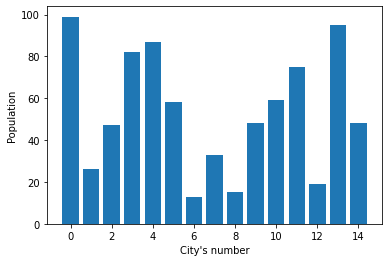

In [0]:
import numpy as np
import matplotlib.pyplot as plt
cities = np.random.randint(10, 100, 15)

plt.bar(np.arange(len(cities)), cities)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

In [0]:
def step(current, cities):
    direction = np.random.choice([-1, 1])
    target = (current + direction) % len(cities)
    ratio = cities[target] / cities[current]
    return target if np.random.rand() < ratio else current

In [0]:
walk = []
current = 1
for i in range(10000):
    current = step(current, cities)
    walk.append(current)

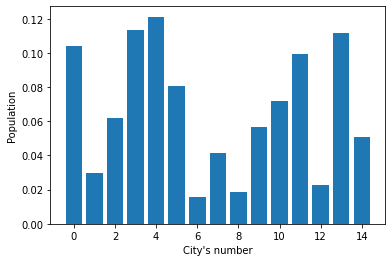

In [0]:
plt.hist(walk, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

In [0]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

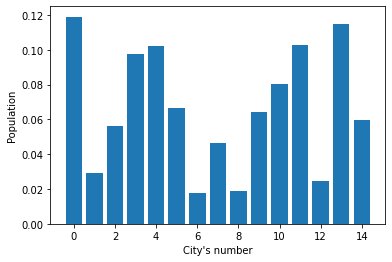

In [0]:
value = lambda x: cities[x]
proposal = lambda x: (x + np.random.choice([-1, 1])) % len(cities)
post = metroplis(1, value, proposal, 10000)

plt.hist(post, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

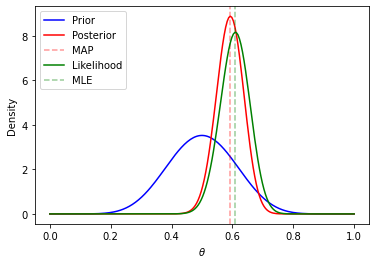

In [0]:
from scipy import stats

a, b = 10, 10

N = 100
X = 61

prior = stats.beta(a, b)
post = stats.beta(X+a, N-X+b)
likelihood = lambda thetas: stats.binom(N, thetas).pmf(X)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.axvline((X + a - 1)/(N + a + b - 2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.axvline(X/N, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

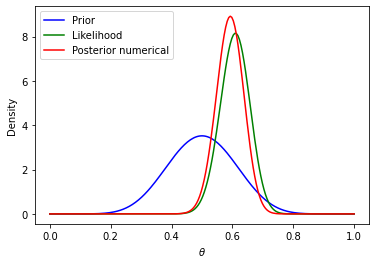

In [0]:
thetas = np.linspace(0, 1, 200)

post = prior.pdf(thetas) * stats.binom(N, thetas).pmf(X)
post /= (post.sum() / len(thetas))

plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior numerical', c='red')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend()
plt.show()

In [0]:
def value(theta, **kwargs):
    _ = kwargs
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(theta) * prior.pdf(theta)

In [0]:
def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

In [0]:
sigma = 0.3

post = metroplis(0.2, value, proposal, 3000, sigma=0.1)

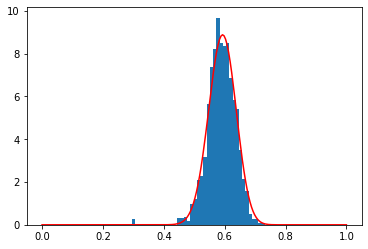

In [0]:
plt.hist(post, bins=50, density=True, label='MCMC posterior')
plt.plot(thetas, stats.beta(X+a, N-X+b).pdf(np.linspace(0, 1, 200)),
         label='True posterior', c='red')
plt.show()

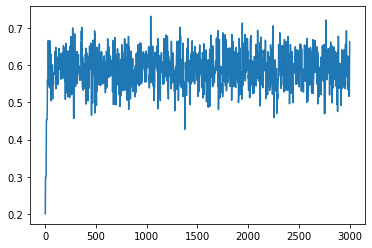

In [0]:
plt.plot(post)
plt.show()

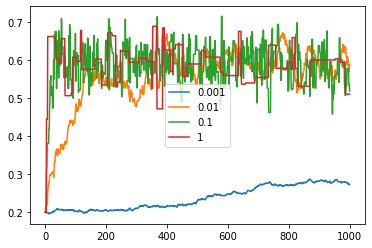

In [0]:
for sigma in [0.001, 0.01, 0.1, 1]:
    post = metroplis(0.2, value, proposal, 1000, sigma=sigma)
    plt.plot(post, label=sigma)
plt.legend()
plt.show()

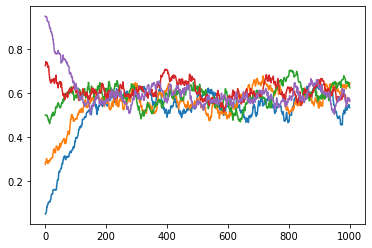

In [0]:
for start in np.linspace(0.05, 0.95, 5):
    post = metroplis(start, value, proposal, 1000, sigma=0.01)
    plt.plot(post)
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


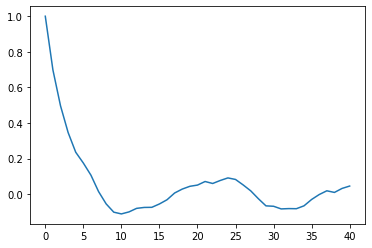

In [0]:
from statsmodels.tsa import stattools

post = metroplis(0.2, value, proposal, 1000, sigma=0.1)

autocorr = stattools.acf(post[100:], fft=False)

plt.plot(autocorr)
plt.show()

In [0]:
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

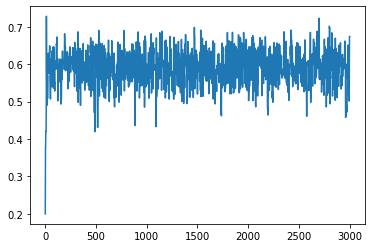

Ttest_indResult(statistic=1.9789919063111514, pvalue=0.04841030742199609)

In [0]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.1)
plt.plot(post)
plt.show()

g_test(post[100:])

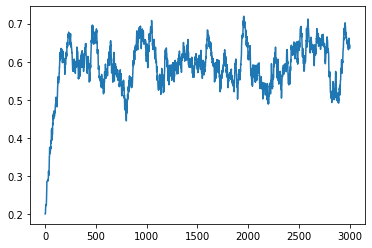

Ttest_indResult(statistic=-9.94896606217995, pvalue=1.789804002052876e-20)

In [0]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.01)
plt.plot(post)
plt.show()

g_test(post)

In [0]:
g_test(post[1000:])

Ttest_indResult(statistic=1.6885265630983057, pvalue=0.09239546797676094)

In [0]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes for a single coin."""
    return theta**z * (1 - theta)**(N - z)

def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes for two coins."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

In [0]:
def make_plots(X, Y, prior, likelihood, posterior):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
    ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
    ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.show()

thetas1 = np.linspace(0.05, 0.95, 100)
thetas2 = np.linspace(0.05, 0.95, 100)
X, Y = np.meshgrid(thetas1, thetas2)

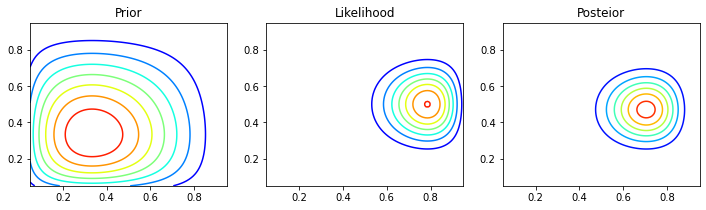

In [0]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
likelihood = lambda theta1, theta2: bern2(theta1, theta2, z1=z1, z2=z2, N1=N1, N2=N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior)

In [0]:
def value(theta, **kwargs):
    _ = kwargs
    theta1, theta2 = theta
    if theta1 < 0 or theta1 > 1:
        return 0
    if theta2 < 0 or theta2 > 1:
        return 0
    return likelihood(theta1, theta2) * prior(theta1, theta2)


def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

theta = np.array([0.2, 0.1])
niters = 5000
nburn = 200
sigma = np.diag([0.2, 0.2])

post = metroplis(theta, value, proposal, niter=niters,
                 nburn=0, sigma=np.array([0.1, 0.1]))

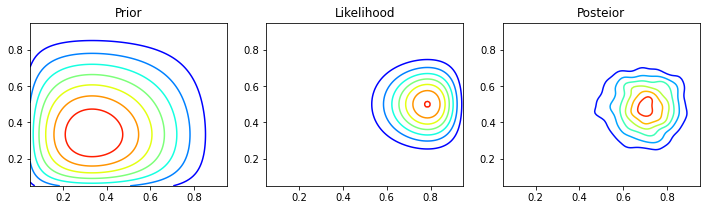

In [0]:
kde = stats.gaussian_kde(np.array(post[nburn:]).T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior_metroplis)

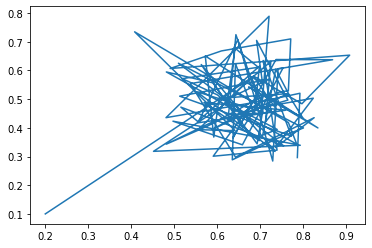

In [0]:
plt.plot(*np.array(post[:100]).T)
plt.show()

In [0]:
theta = np.array([0.2, 0.1])

post = [theta]
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]
    post.append(theta)

# Задача

Оценить  En(ξ)  с помощью МСМС для графа 8х8

Обосновать численно и графически стационарность

Построить график распределеиня  n(ξ)

Вспомогательная функция для раскраски вершин графа в соответствии с переданной маской:

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray
        Mask for vertices colors
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.empty(narr.shape, dtype='U5')
    colors[:] = 'red'
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

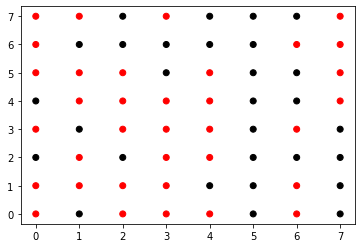

In [0]:
size = 8
narr = np.random.choice([0, 1], size=size**2).reshape((size, size)).astype('bool')

plot_grid(narr)

In [0]:

def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    post = [0]
    temp = 0
    current = start
    for i in range(niter):
        temp = value(current, **kwargs)
        index = np.random.choice(8,2)
        proposed = proposal(current, index, **kwargs)
        p = value(proposed, **kwargs)/temp
        if np.random.uniform() > p:
            current = proposed
        else :
            current[index[0]][index[1]] = 0;
        post.append(int(np.sum(current)))
    return post[nburn:]

In [0]:
def value(theta, **kwargs):
    _ = kwargs
    return current.sum()

In [0]:
def proposal(current, place, **kwargs):
    _ = kwargs
    place = np.random.choice(8,2)
    
    summ = 0
    if place[0]!=0:
        summ+=current[place[0]-1][place[1]]
    if place[0]!=7:
        summ+=current[place[0]+1][place[1]]
    if place[1]!=0:
        summ+=current[place[0]][place[1]-1]
    if place[1]!=7:
        summ+=current[place[0]][place[1]+1]
    if summ==0:
        current[place[0]][place[1]] = 1
    else:
        current[place[0]][place[1]] = 0
    return current

In [0]:
post = metroplis(np.zeros((8,8)), value, proposal, 100000)


Расчитаем E𝑛(𝜉)

In [0]:
E = np.mean(post)
D = np.std(post)
print('Математичесское ожидание = ',E )
print('Среднеквадратическое отклонение = ', D)

Математичесское ожидание =  15.254717452825473
Среднеквадратическое отклонение =  2.095765838082064


Проверяем стационарность

In [0]:
def g_test(x, start=0.1, end=0.1):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

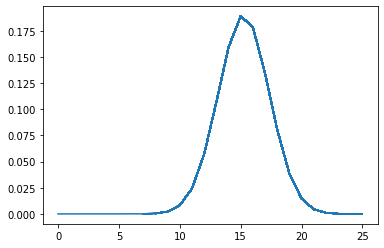

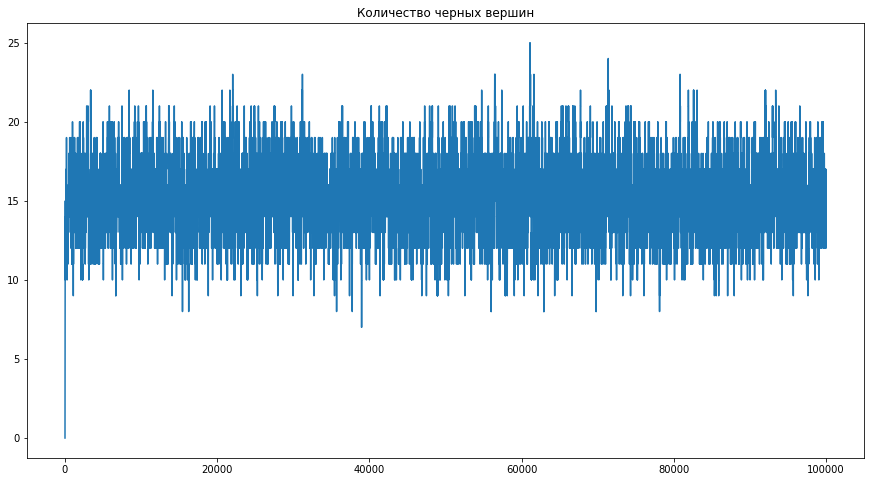

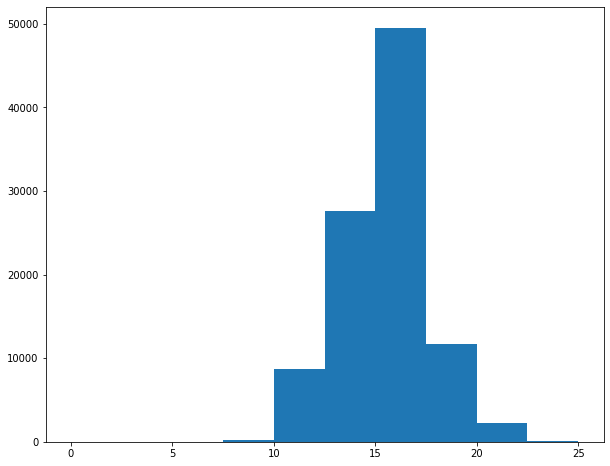

Ttest_indResult(statistic=-16.752486143612863, pvalue=5.394461545042872e-59)

In [0]:
from scipy import stats

rv_norm = stats.norm(loc = E,scale = D)
pdf = rv_norm.pdf(post)
plt.plot(post,pdf)
plt.show()

plt.figure(figsize=(15,8))
plt.plot(post)
plt.title("Количество черных вершин")
plt.show()

plt.figure(figsize=(10,8))
plt.hist(post)
plt.show()

g_test(post[:10000])

Здесь мы видим что наше распределение близко к нормальному